In [6]:
# 필요 모듈 불러오기
import nltk
import os
nltk.download('stopwords')
import requests
from nltk.corpus import stopwords
from summa.summarizer import summarize
import pandas as pd
import numpy as np
import urllib
import re
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Tensorflow 동작 디바이스를 GPU로 설정
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZAKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# 데이터 불러오기
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

headlines  \
27030  Senior bankers get up to 4 yrs jail in 1992 se...   
23065  US judge orders to shut defendant's mouth with...   
70863  Google calls NYT report on gender pay gap 'ext...   
45968  UP bride takes 'baaraat' to groom's house brea...   
43025  Rohit gifted VIP tickets for final to injured ...   
83773  London tower fire began in a fridge freezer, c...   
18273  Alia gets Kathak training for dance with Madhu...   
75196  India capable of tackling any security challen...   
82893  T'gana hospital turns away pregnant women sayi...   
32134  Pic of MP leaning against wall before Putin oa...   

                                                    text  
27030  Five people, including senior bank officials, ...  
23065  A judge in the US state of Ohio ordered to shu...  
70863  Search giant Google has called The New York Ti...  
45968  A bride arrived at the groom's residence in Va...  
43025  Team India stand-in captain Rohit Sharma gifte...  
83773  The London Police on Friday confirmed that the...  
18273  Alia Bhatt is undergoing training in Kathak as...  
75196  Prime Minister Narendra Modi on Tuesday said, ...  
82893  Several pregnant women protested outside a gov...  
32134  A picture of Russian MP Natalya Poklonskaya le...

In [8]:
# 텍스트 정규화 준비
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english'))
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# text 열의 데이터를 전처리하여 리스트에 저장
preprocessed_text = []

for sentence in data['text']:
    preprocessed_sentence = preprocess_sentence(sentence)
    preprocessed_text.append(preprocessed_sentence)

In [11]:
# headlines 열의 데이터를 전처리하여 리스트에 저장
preprocessed_headlines = []

for sentence in data['headlines']:
    sentence = preprocess_sentence(sentence)
    preprocessed_headlines.append(sentence)

In [12]:
# 전처리된 데이터를 데이터셋의 text 열로 대체
data['text'] = preprocessed_text
data['headlines'] = preprocessed_headlines

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.19471346835906
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.201969492179957


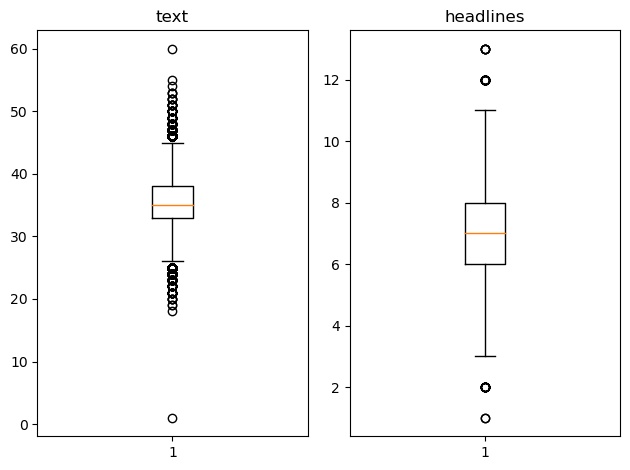

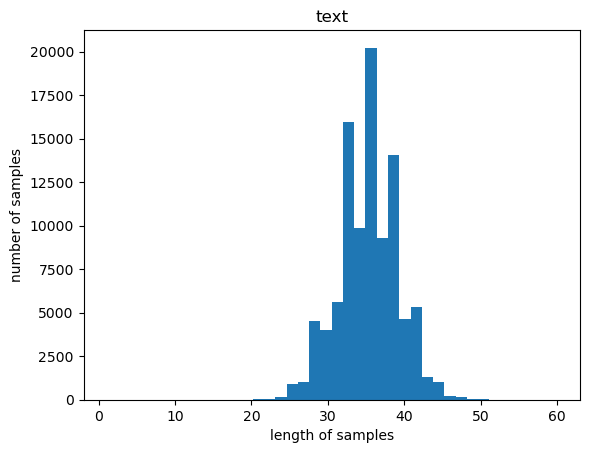

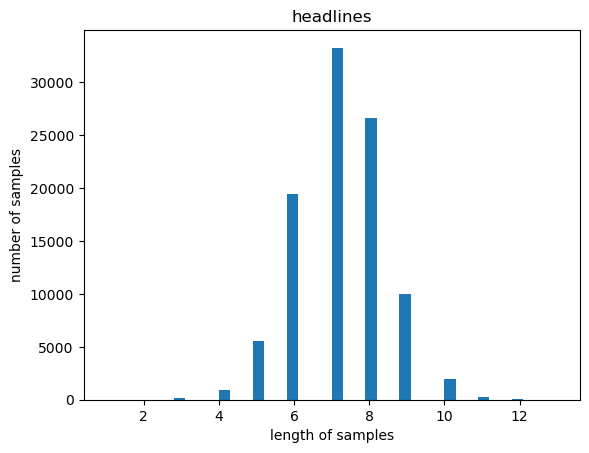

In [13]:
# text와 headlines의 데이터들의 최소 및 최대, 평균 길이 등을 조사
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 데이터들의 길이 분포를 그래프로 확인
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 모델에 입력할 데이터들의 최대 길이를 임의로 지정
text_max_len = 45
headlines_max_len = 12


In [15]:
# 최대 길이를 넘는 데이터들을 훈련에서 제외
def filter_samples(row):
    text_len = len(row['text'].split())
    headlines_len = len(row['headlines'].split())
    return text_len <= text_max_len and headlines_len <= headlines_max_len

filtered_data = data[data.apply(lambda row: filter_samples(row), axis=1)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [16]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

headlines  \
0   upgrad learner switches career ml al salary hike   
1   delhi techie wins free food swiggy one year cred   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
4           known hirani yrs metoo claims true sonam   

                                                text  \
0  saurav kant alumnus upgrad iiit b pg program m...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   

                                       decoder_input  \
0  sostoken upgrad learner switches career ml al ...   
1  sostoken delhi techie wins free food swiggy on...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life iterm insurance plan helps...   
4  sostoken known hirani yrs metoo claims true sonam   

                                      decoder_target  
0  upgrad learner switches career ml al salary hi...  
1  delhi techie wins free food swiggy one year cr...  
2  new zealand end rohit sharma led india match w...  
3  aegon life iterm insurance plan helps customer...  
4  known hirani yrs metoo claims true sonam eostoken

In [17]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [18]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.
# (훈련 데이터와 테스트 데이터를 분리하기 위한 작업)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [19]:
# 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)

# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78721
훈련 레이블의 개수 : 78721
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


In [20]:
# 단어 집합(vocabulary)을 만든다. (각 단어에 고유한 정수를 맵핑)
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [21]:
# 등장 빈도 수가 낮은 데이터들을 제외하기 위해 7회 미만의 데이터들의 비중을 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69741
등장 빈도가 6번 이하인 희귀 단어의 수: 47580
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22161
단어 집합에서 희귀 단어의 비율: 68.22385684174303
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.494548655688784


In [22]:
# 등장 빈도가 6회 이하인 단어들은 훈련에서 제외하고, 단어 집합의 크기를 8,000으로 제한
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train.tolist())

In [23]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [24]:
# headlines 데이터에 대해서도 동일한 작업을 수행
# ecoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [25]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29917
등장 빈도가 5번 이하인 희귀 단어의 수: 19576
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10341
단어 집합에서 희귀 단어의 비율: 65.43436841929338
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.802067864481632


In [26]:
# 2,000을 단어 집합의 크기로 제한
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 247, 316, 25, 1797, 195, 769, 40], [1, 586, 15, 344, 25, 1215, 416], [1, 3, 946, 75, 51, 4], [1, 107, 1658, 990, 102, 125, 34], [1, 291, 1702, 32]]
target
decoder  [[247, 316, 25, 1797, 195, 769, 40, 2], [586, 15, 344, 25, 1215, 416, 2], [3, 946, 75, 51, 4, 2], [107, 1658, 990, 102, 125, 34, 2], [291, 1702, 32, 2]]


In [27]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장, 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 236
삭제할 테스트 데이터의 개수 : 61
훈련 데이터의 개수 : 78485
훈련 레이블의 개수 : 78485
테스트 데이터의 개수 : 19619
테스트 레이블의 개수 : 19619


In [28]:
# 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [29]:
# 모델 설계
# 함수형 API를 이용해서 인코더를 설계
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [30]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [31]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [32]:
# Tensorflow에서 Bahdanau 스타일의 어텐션 함수를 가져온다.
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [33]:
# 훈련 개시
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

# EarlyStopping을 작동하여 최적점의 훈련 지점에서 훈련 정지
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

Epoch 1/50
307/307 [==============================] - 23s 54ms/step - loss: 3.0488 - val_loss: 2.8133
Epoch 2/50
307/307 [==============================] - 15s 48ms/step - loss: 2.6477 - val_loss: 2.4986
Epoch 3/50
307/307 [==============================] - 14s 47ms/step - loss: 2.4159 - val_loss: 2.3591
Epoch 4/50
307/307 [==============================] - 14s 47ms/step - loss: 2.2723 - val_loss: 2.2312
Epoch 5/50
307/307 [==============================] - 14s 47ms/step - loss: 2.1597 - val_loss: 2.1540
Epoch 6/50
307/307 [==============================] - 14s 47ms/step - loss: 2.0653 - val_loss: 2.0920
Epoch 7/50
307/307 [==============================] - 14s 46ms/step - loss: 1.9838 - val_loss: 2.0365
Epoch 8/50
307/307 [==============================] - 14s 47ms/step - loss: 1.9126 - val_loss: 1.9891
Epoch 9/50
307/307 [==============================] - 14s 47ms/step - loss: 1.8489 - val_loss: 1.9574
Epoch 10/50
307/307 [==============================] - 14s 46ms/step - loss: 1.792

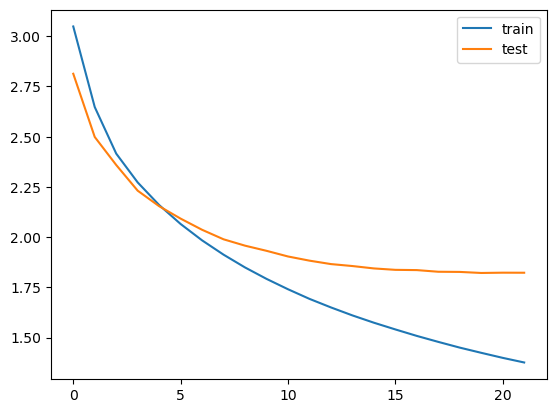

In [34]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 준비
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [36]:
# 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함.
# 이때는 인코더 모델과 디코더 모델을 분리해서 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [37]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [38]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [39]:
# 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 설계

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [40]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 헤드라인과 예측된 헤드라인을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : karnataka chief minister siddaramaiah tuesday clarified list congress candidates circulation upcoming state assembly polls fake adding approved list candidates yet chief minister said please products factory meanwhile bjp released first list candidates polls 
실제 요약 : fake cong k taka poll candidate list cm 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  karnataka cm blames list karnataka polls


원문 : reacting backlash letter sanjay leela bhansali actress swara bhasker said unfortunate different opinion could seen could passed sedition added real problem opinion india swara earlier said felt reduced watching padmaavat 
실제 요약 : see swara 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  swara


원문 : malayalam actress priya prakash followers instagram facebook co founder mark zuckerberg whose company also owns photo sharing app priya crossed million followers zuckerberg currently million followers platform actress became popular song upcoming film love went 

In [62]:
# summarize() 메서드를 이용하여 추출적 요약 시행
print('Summary:')
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
for sentence in data['text']:
    print(summarize(sentence, ratio=0.35, words=10))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.

The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.



India's previous lowest ODI total in New Zealand was 108.







"It was a very emotional affair for everyone in my family," said Isha.






It'll also pursue activities for sustained human space flight missions, ISRO added.

Reliance Industries' Chairman Mukesh Ambani's daughter Isha Ambani has featured on the cover of the February edition of Vogue India.

Ambrose ended with first-innings figures of 18-9-25-7.
The names will appear on zoo's 'roach board' on February 14.
Rohit scored 7,799 runs in his first 199 ODIs at an average of 48.14.
Notably, Shubman was named Player of the Under-19 World Cup in New Zealand last year.






Mahuwala was a member of a gang who ordered costly gadgets from Amazon.
AgustaWestland chopper scam co-accused Rajiv Saxena was extradited to India from UAE on Wednesday.


"I absolutely 